- include pdf of analysis once done
- duplicate and make week_4.ipynb with visuals i actually used

In [2]:
# all imports

import pyarrow.csv as pv
import pyarrow.parquet as pq
import pyarrow as pa
import polars as pl

In [ ]:
# preprocessing function (polars)

csv_file = "2022_place_canvas_history.csv"
parquet_file = "2022pyarrow.parquet"

DATESTRING_FORMAT = "%Y-%m-%d %H:%M:%S"
BLOCK_SIZE = 100_000_000

read_options = pv.ReadOptions(block_size=BLOCK_SIZE)
csv_reader = pv.open_csv(csv_file, read_options=read_options)

parquet_writer = None

try:
    for record_batch in csv_reader:
        print(f"Processing batch with {record_batch.num_rows} rows...")

        df = pl.from_arrow(record_batch)

        # convert timstamp to datetime object
        df = df.with_columns(
            pl.col("timestamp")
            .str.replace(r" UTC$", "")  
            .str.strptime(
                pl.Datetime, 
                format="%Y-%m-%d %H:%M:%S%.f",
                strict=False
            )
            .alias("timestamp")
        )

        # split coordinate into cols 'x', 'y' 
        df = (
            df.filter(
                pl.col("coordinate").str.count_matches(",") == 1
            )
            .with_columns(
                pl.col("coordinate")
                .str.split_exact(",", 1)
                .struct.field("field_0")
                .cast(pl.Int64)
                .alias("x"),
                pl.col("coordinate")
                .str.split_exact(",", 1)
                .struct.field("field_1")
                .cast(pl.Int64)
                .alias("y"),
            )
            .drop("coordinate")
            )

        # map user_id to ints to save memory
        df = df.with_columns(
            pl.col('user_id')
            .cast(pl.Categorical)  # convert to categorical (assigns unique codes)
            .to_physical()         # get int rep
            .alias('user_id_int')
        )
        df = df.drop("user_id") # can drop user_id now

        table = df.to_arrow()

        if parquet_writer is None:
            parquet_writer = pq.ParquetWriter(
                parquet_file, 
                schema=table.schema, 
                compression="zstd"
            )
        parquet_writer.write_table(table)

finally:
    if parquet_writer:
        parquet_writer.close()

print(f"Successfully converted {csv_file} to {parquet_file}")

In [20]:
parquet_file = pq.ParquetFile("2022pyarrow.parquet")

row_count = parquet_file.metadata.num_rows
columns = parquet_file.schema.names

print(f"Number of rows: {row_count}")
print(f"Columns: {columns}")
# and parquet is 1.45 GB

Number of rows: 160353085
Columns: ['timestamp', 'pixel_color', 'x', 'y', 'user_id_int']


In [ ]:
# can retrieve original user_id with: 

# df.with_columns(
#     pl.col('user_id_int')
#     .reverse()
#     .alias('user_id')
# )

# What are the top 3 most painted pixels?

In [125]:
parquet_file = "2022pyarrow.parquet"

lf = pl.scan_parquet(parquet_file)  # LazyFrame (efficient for big data)
lf.collect().head()

timestamp,pixel_color,x,y,user_id_int
datetime[μs],str,i64,i64,u32
2022-04-04 00:53:51.577,"""#00CCC0""",826,1048,0
2022-04-04 00:53:53.758,"""#94B3FF""",583,1031,1
2022-04-04 00:53:54.685,"""#6A5CFF""",1873,558,2
2022-04-04 00:54:57.541,"""#009EAA""",1627,255,3
2022-04-04 00:55:16.307,"""#94B3FF""",49,1478,4


In [9]:
top3_paint_counts = (
    lf.group_by(['x', 'y'])
    .agg(pl.len().alias('count')) # count occurances
    .sort('count', descending=True) # sort by count
    .limit(3) # top 3 pixels
)

top3_paint_counts.collect()

x,y,count
i64,i64,u32
0,0,98807
359,564,69198
349,564,55230


The top 3 painted pixels are at locations
1. (0, 0) painted 98807 times
2. (359, 564) painted 69198 times
3. (349, 564) painted 55230 times 

"The 2022 edition started with the same size and colors as 2017, but the canvas was later expanded to four million (2000 x 2000) pixel squares, and the palette gradually gained sixteen more colors for a total of 32."

- (0, 0) is located at the upper left corner of the canvas
- x move to right
- y move down

# Simple EDA: Why were the 3 most painted pixels hit so often?

## 1. Visualize positioning of pixels?
- distribution of count of painted pixels (entire count?)
- maybe visualization of concentration of how often pixels painted on entire canvas?
- were pixels near the top painted pixels, also hit pretty often?

In [21]:
paint_counts = (
    lf.group_by(['x', 'y'])
    .agg(pl.len().alias('count')) # count occurances
    .sort('count', descending=True) # sort by count
)

paint_counts.collect().head(10)

x,y,count
i64,i64,u32
0,0,98807
359,564,69198
349,564,55230
859,766,52261
860,766,51485
104,768,38086
105,768,34082
1999,1999,31437
1999,0,30882


^^ see some clustering in pairs

### Visualize with Heatmap

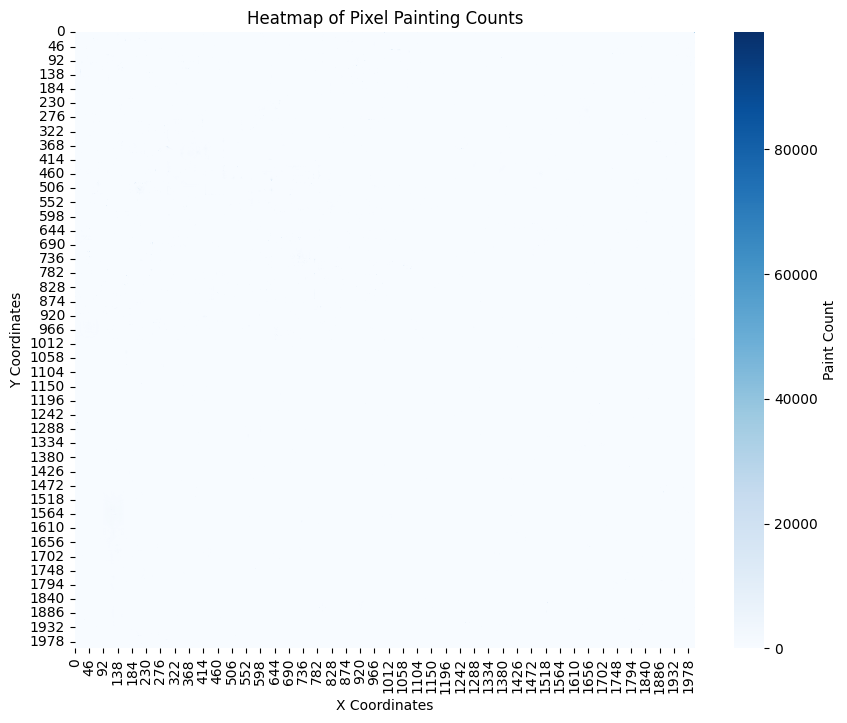

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

paint_counts_pd = paint_counts.collect().to_pandas() # need to convert to pandas to plot

heatmap_data = paint_counts_pd.pivot(index='y', columns='x', values='count').fillna(0) # define heatmap, pivot for grid-like structure

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='Blues', annot=False, fmt='g', cbar_kws={'label': 'Paint Count'})
plt.title('Heatmap of Pixel Painting Counts')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.show()

^^ can't see each pixel since range of pixel counts is really high (0 - 97k)

Try by zooming in -> split into 4 sections (top left, bottom left, top right, bottom right) with smaller range of pixel counts

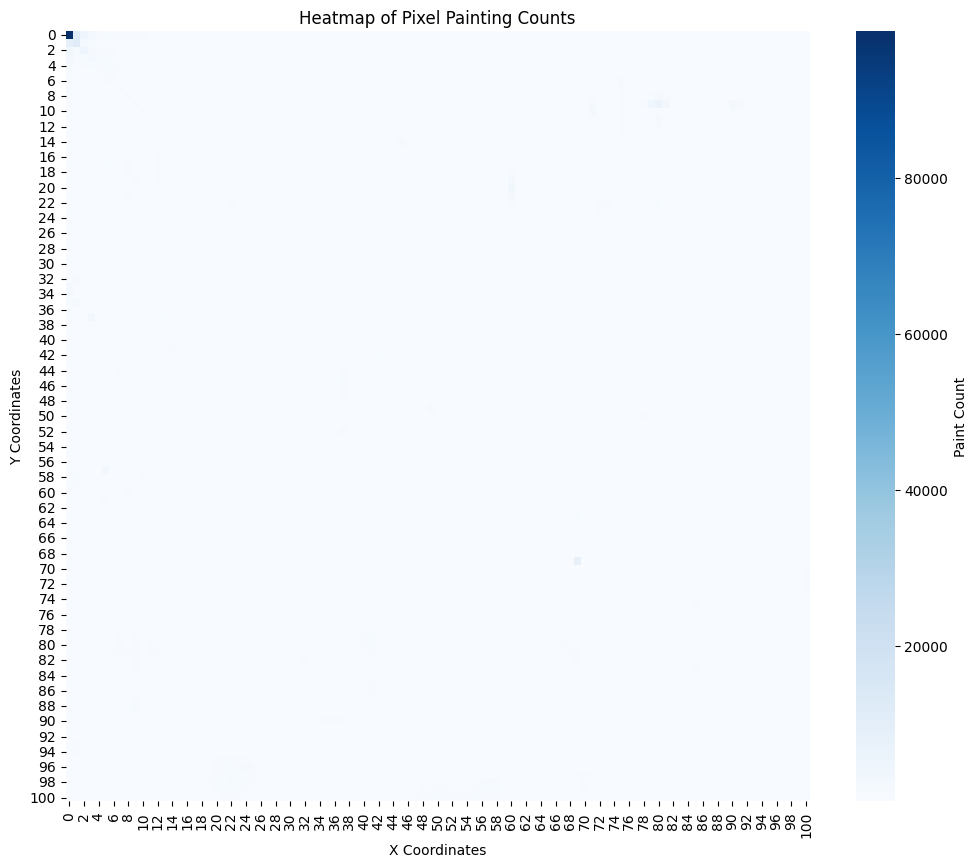

In [58]:
# try heatmap again (with fixes)

plt.figure(figsize=(12, 10))  # increase plot size
sns.heatmap(heatmap_data.loc[0:100, 0:100], cmap='Blues', annot=False, fmt='g', # try zooming in
            cbar_kws={'label': 'Paint Count'}) 

 
# plt.gca().invert_yaxis() # somehow put plot in top left corner
plt.title('Heatmap of Pixel Painting Counts')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.show()

# This plot shows top left section of canvas (0:100, 0:100).

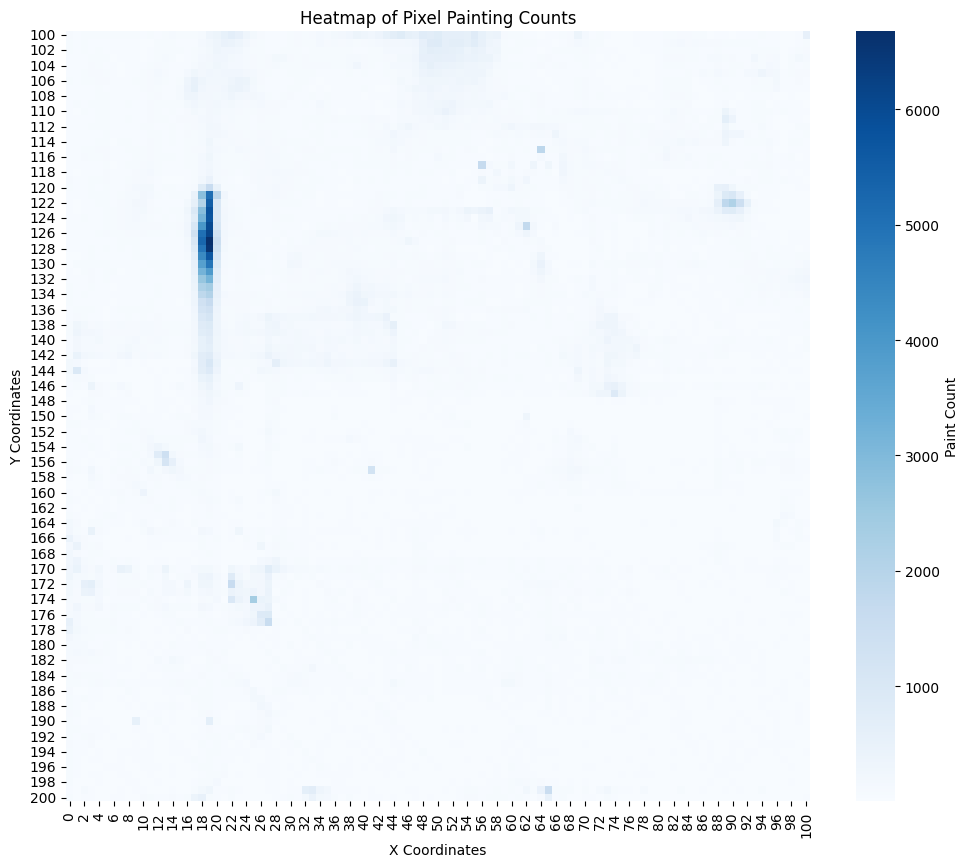

In [60]:
plt.figure(figsize=(12, 10))  # increase plot size
sns.heatmap(heatmap_data.loc[100:200, 0:100], cmap='Blues', annot=False, fmt='g', # try zooming in
            cbar_kws={'label': 'Paint Count'}) 

 
# plt.gca().invert_yaxis() # somehow put plot in top left corner
plt.title('Heatmap of Pixel Painting Counts')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.show()

# This plot shows top right section of canvas (0:100, 0:100).

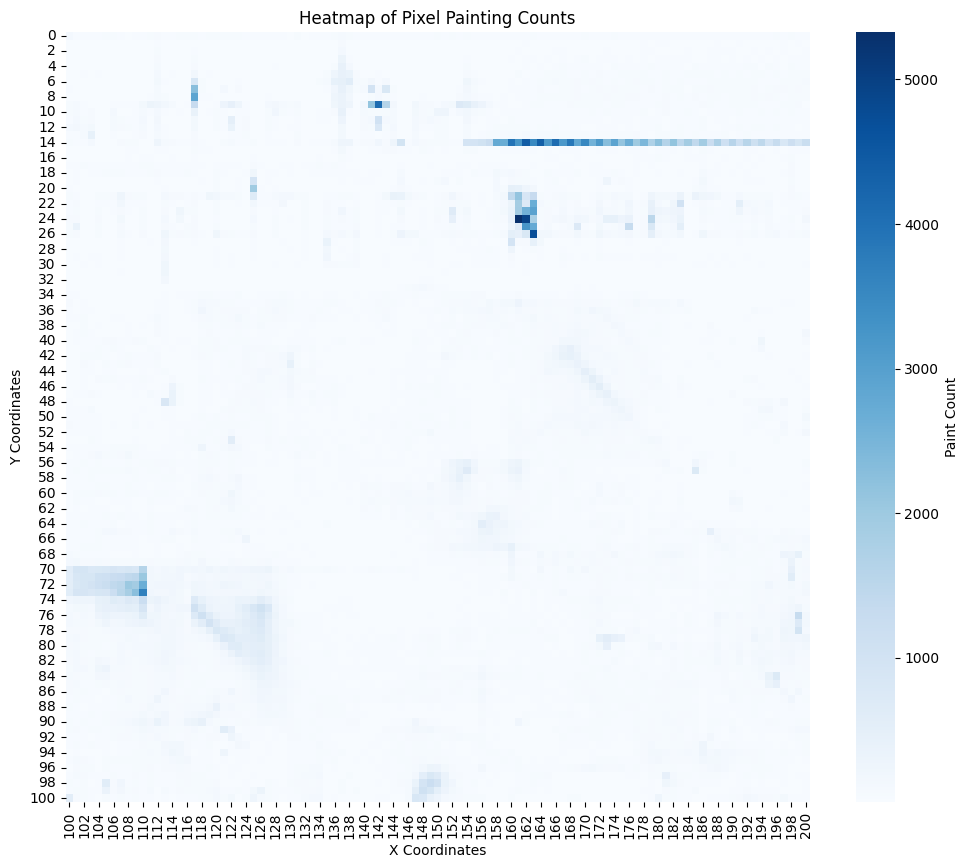

In [43]:
plt.figure(figsize=(12, 10))  # increase plot size
sns.heatmap(heatmap_data.loc[0:100, 100:200], cmap='Blues', annot=False, fmt='g', # try zooming in
            cbar_kws={'label': 'Paint Count'}) 

 
# plt.gca().invert_yaxis() # somehow put plot in top left corner
plt.title('Heatmap of Pixel Painting Counts')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.show()

# This plot shows bottom left section of canvas (0:100, 100:200).

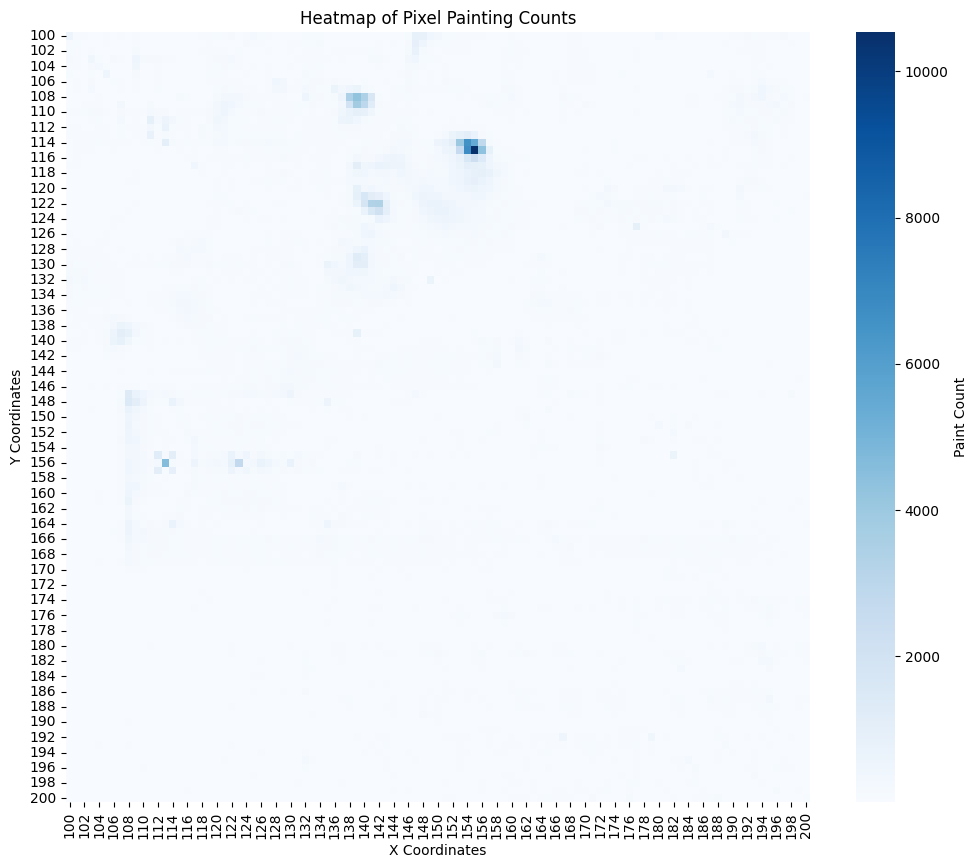

In [44]:
plt.figure(figsize=(12, 10))  # increase plot size
sns.heatmap(heatmap_data.loc[100:200, 100:200], cmap='Blues', annot=False, fmt='g', # try zooming in
            cbar_kws={'label': 'Paint Count'}) 

 
# plt.gca().invert_yaxis() # somehow put plot in top left corner
plt.title('Heatmap of Pixel Painting Counts')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.show()

# This plot shows bottom right section of canvas (100:200, 100:200).

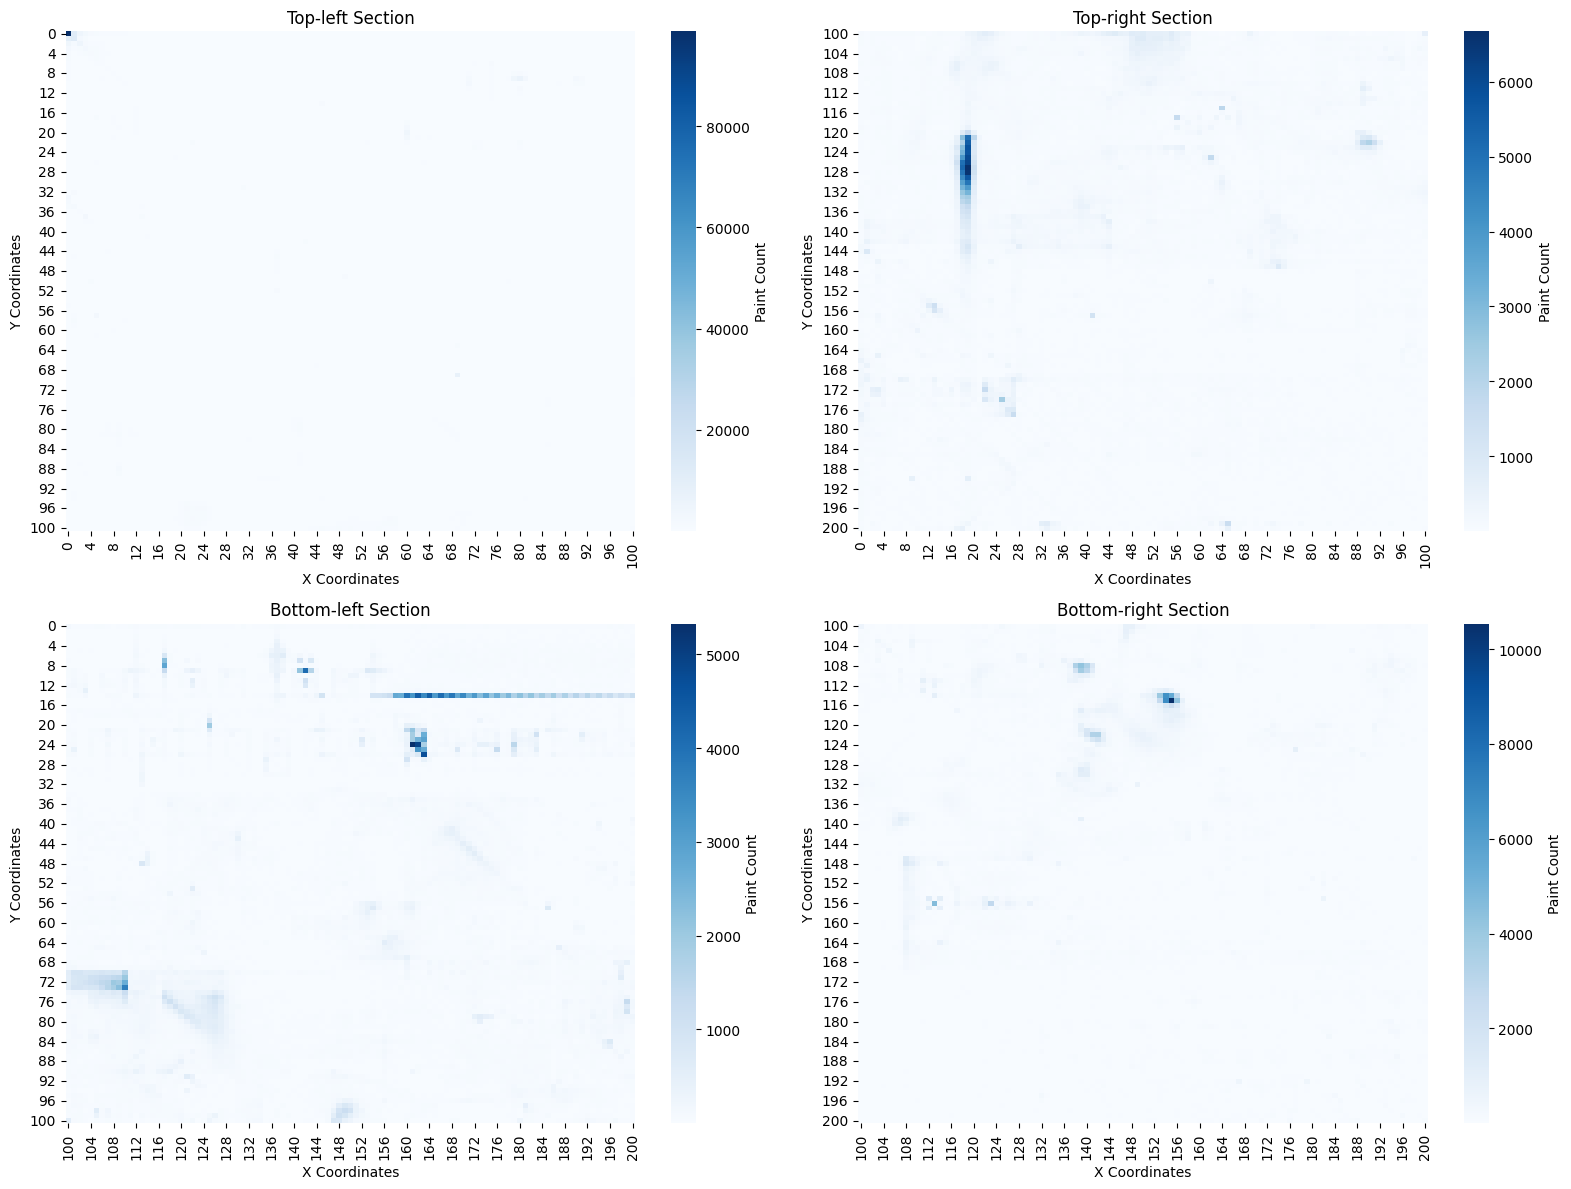

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12)) # 2 rows, 2 cols for 4 sections

# Top-left section (0:100, 0:100)
sns.heatmap(heatmap_data.loc[0:100, 0:100], cmap='Blues', annot=False, fmt='g', 
            cbar_kws={'label': 'Paint Count'}, ax=axs[0, 0])
axs[0, 0].set_title('Top-left Section')
axs[0, 0].set_xlabel('X Coordinates')
axs[0, 0].set_ylabel('Y Coordinates')

# Top-right section (100:200, 0:100)
sns.heatmap(heatmap_data.loc[100:200, 0:100], cmap='Blues', annot=False, fmt='g', 
            cbar_kws={'label': 'Paint Count'}, ax=axs[0, 1])
axs[0, 1].set_title('Top-right Section')
axs[0, 1].set_xlabel('X Coordinates')
axs[0, 1].set_ylabel('Y Coordinates')

# Bottom-left section (0:100, 100:200)
sns.heatmap(heatmap_data.loc[0:100, 100:200], cmap='Blues', annot=False, fmt='g', 
            cbar_kws={'label': 'Paint Count'}, ax=axs[1, 0])
axs[1, 0].set_title('Bottom-left Section')
axs[1, 0].set_xlabel('X Coordinates')
axs[1, 0].set_ylabel('Y Coordinates')

# Bottom-right section (100:200, 100:200)
sns.heatmap(heatmap_data.loc[100:200, 100:200], cmap='Blues', annot=False, fmt='g', 
            cbar_kws={'label': 'Paint Count'}, ax=axs[1, 1])
axs[1, 1].set_title('Bottom-right Section')
axs[1, 1].set_xlabel('X Coordinates')
axs[1, 1].set_ylabel('Y Coordinates')

plt.tight_layout()
plt.show()


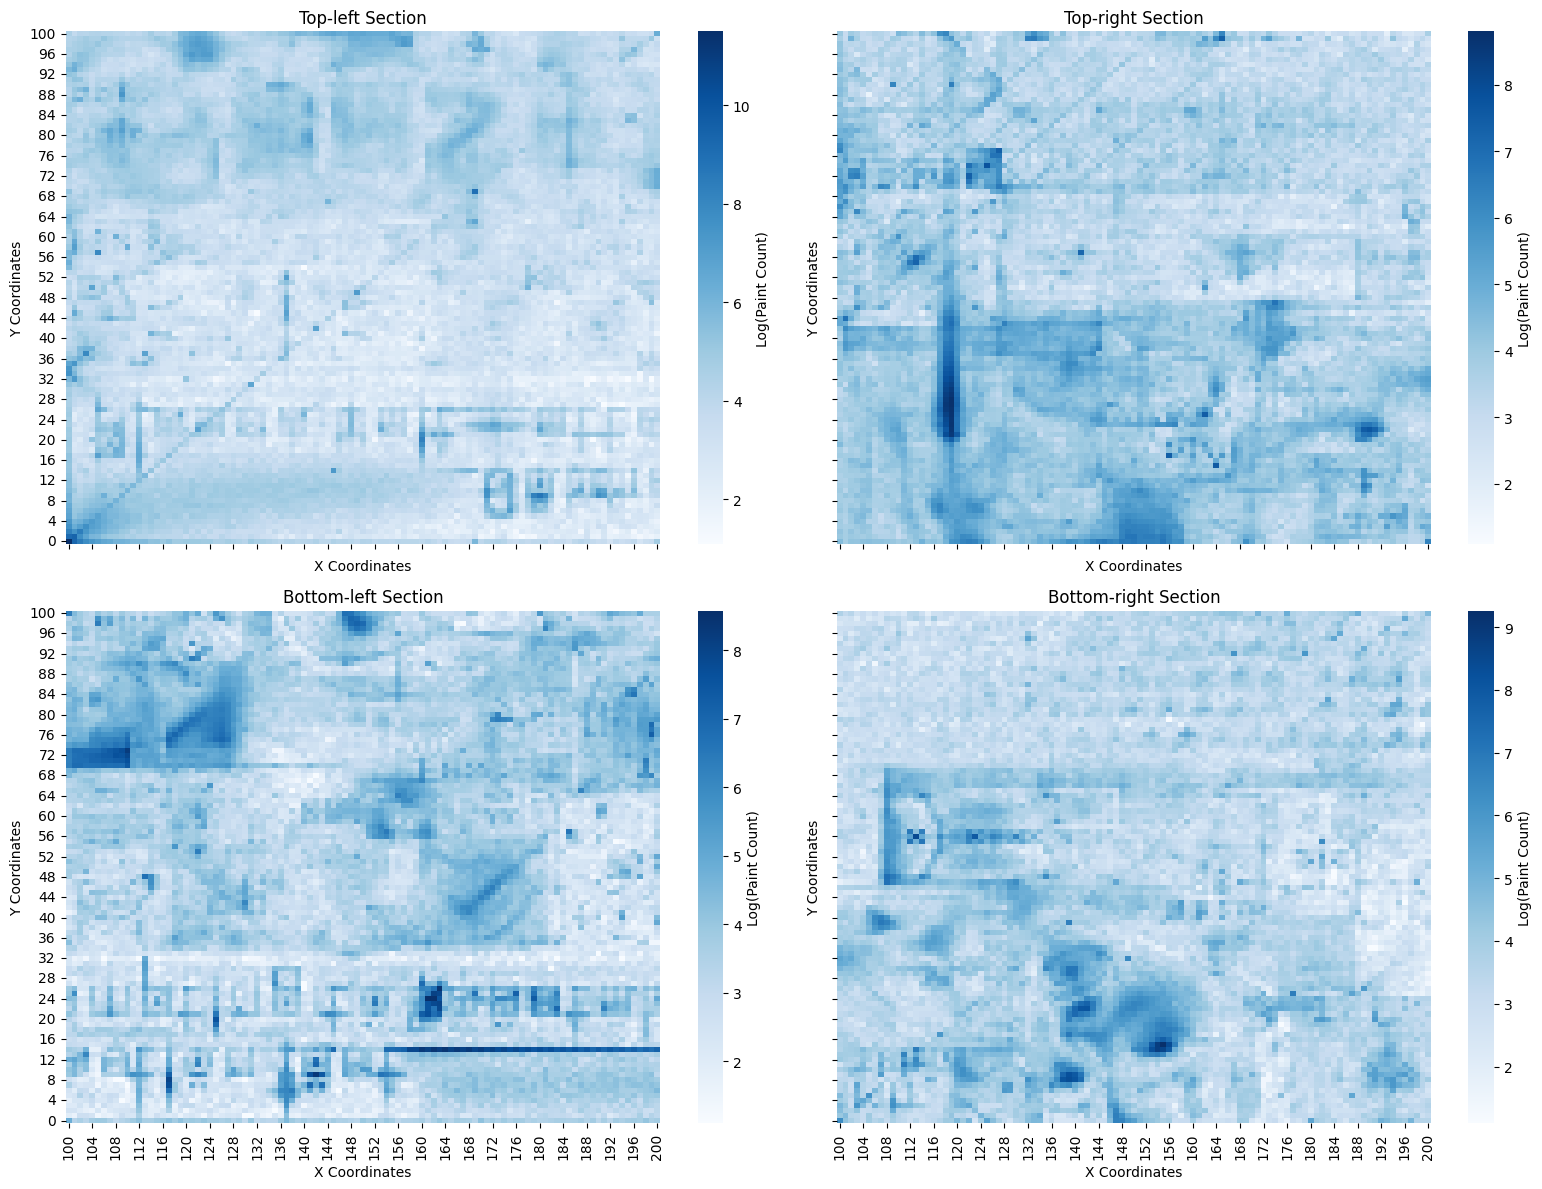

In [ ]:
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# try log scale to normalize different scales?
log_heatmap_data = np.log1p(heatmap_data)  # apply log transformation (log(x+1))

# Top-left section (0:100, 0:100)
sns.heatmap(log_heatmap_data.loc[0:100, 0:100], cmap='Blues', annot=False, fmt='g', 
            cbar_kws={'label': 'Log(Paint Count)'}, ax=axs[0, 0])
axs[0, 0].invert_yaxis()  # Flip y-axis
axs[0, 0].set_title('Top-left Section')
axs[0, 0].set_xlabel('X Coordinates')
axs[0, 0].set_ylabel('Y Coordinates')

# Top-right section (100:200, 0:100)
sns.heatmap(log_heatmap_data.loc[100:200, 0:100], cmap='Blues', annot=False, fmt='g', 
            cbar_kws={'label': 'Log(Paint Count)'}, ax=axs[0, 1])
axs[0, 1].invert_yaxis()  # Flip y-axis
axs[0, 1].set_title('Top-right Section')
axs[0, 1].set_xlabel('X Coordinates')
axs[0, 1].set_ylabel('Y Coordinates')

# Remove x-axis labels for the top-left and top-right plots
axs[0, 0].set_xticklabels([])  # Top-left
axs[0, 1].set_xticklabels([])  # Top-right

# Bottom-left section (0:100, 100:200)
sns.heatmap(log_heatmap_data.loc[0:100, 100:200], cmap='Blues', annot=False, fmt='g', 
            cbar_kws={'label': 'Log(Paint Count)'}, ax=axs[1, 0])
axs[1, 0].invert_yaxis()  # Flip y-axis
axs[1, 0].set_title('Bottom-left Section')
axs[1, 0].set_xlabel('X Coordinates')
axs[1, 0].set_ylabel('Y Coordinates')

# Bottom-right section (100:200, 100:200)
sns.heatmap(log_heatmap_data.loc[100:200, 100:200], cmap='Blues', annot=False, fmt='g', 
            cbar_kws={'label': 'Log(Paint Count)'}, ax=axs[1, 1])
axs[1, 1].invert_yaxis()  # Flip y-axis
axs[1, 1].set_title('Bottom-right Section')
axs[1, 1].set_xlabel('X Coordinates')
axs[1, 1].set_ylabel('Y Coordinates')

# Remove y-axis labels for the top-right and bottom-right plots
axs[0, 1].set_yticklabels([])  # Top-right
axs[1, 1].set_yticklabels([])  # Bottom-right

plt.tight_layout()
plt.show()


### Try Visualization with Scatterplot (that behaves like Heatmap)

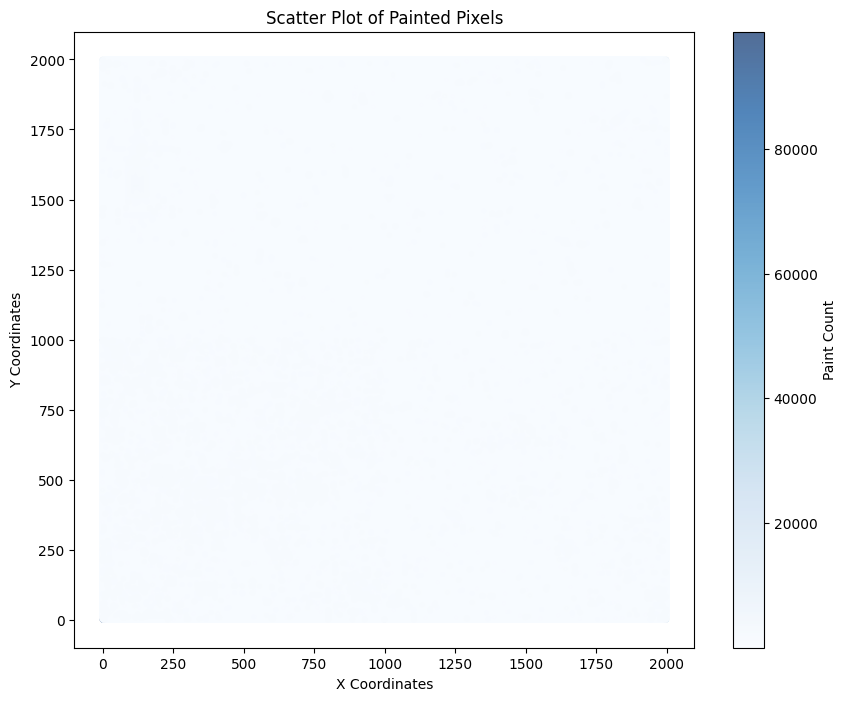

In [57]:
# scatterplot for painted pixels

plt.figure(figsize=(10, 8))
plt.scatter(paint_counts_pd['x'], paint_counts_pd['y'], c=paint_counts_pd['count'], cmap='Blues', s=10, alpha=0.7)
plt.colorbar(label='Paint Count')
plt.title('Scatter Plot of Painted Pixels')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.show()

# same challenge as HeatMap

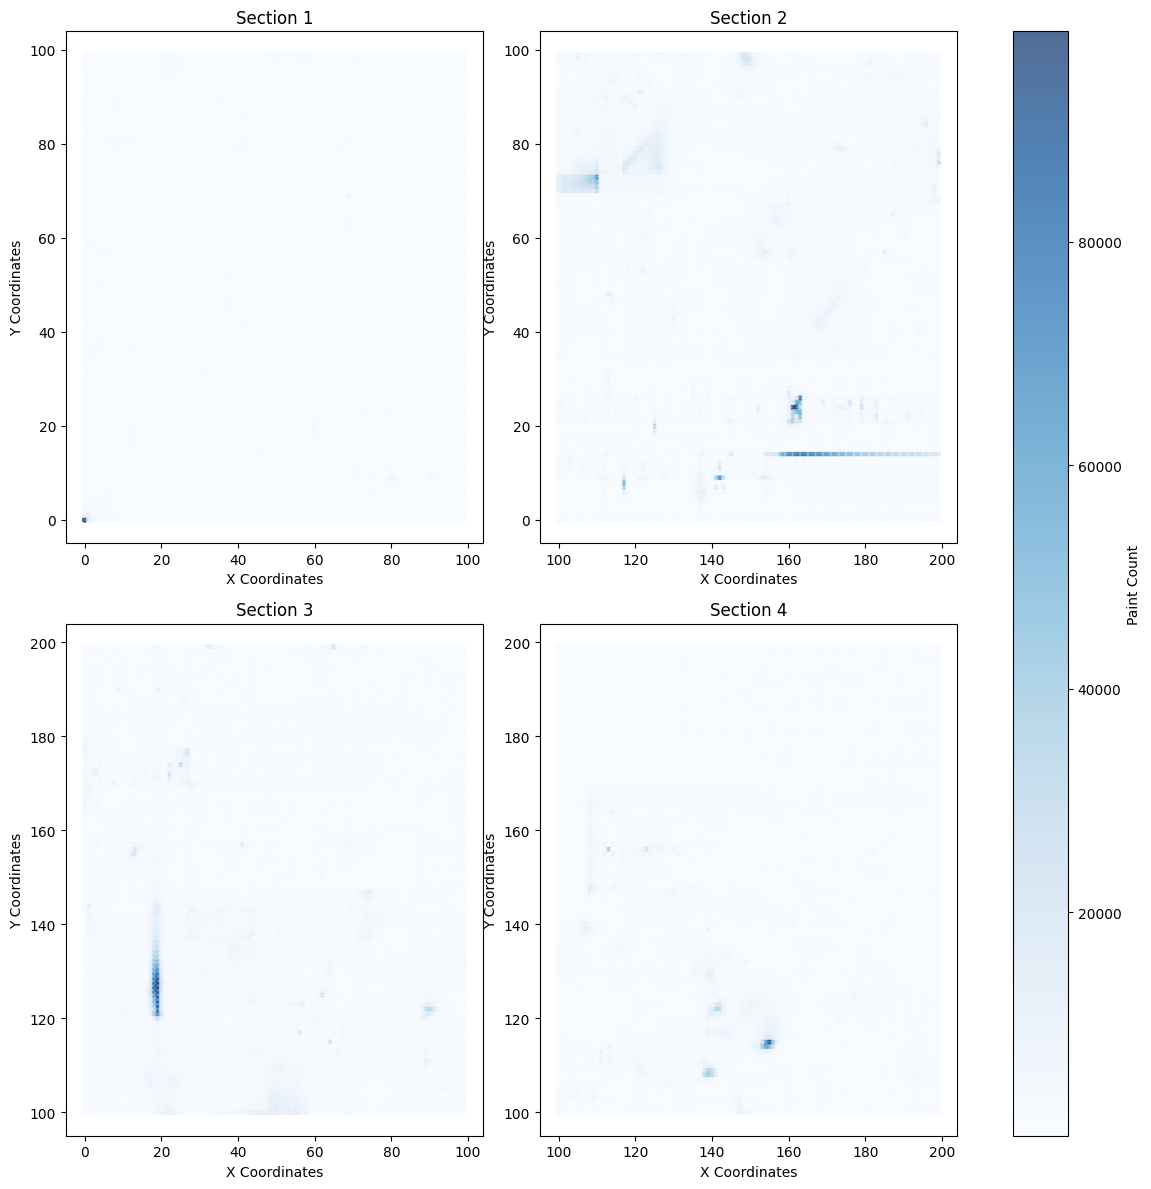

In [ ]:
# plot a section of the canvas
def plot_section(ax, x_min, x_max, y_min, y_max, data, title):

    # filter data to specified section
    section_data = data[(data['x'] >= x_min) & (data['x'] < x_max) & 
                        (data['y'] >= y_min) & (data['y'] < y_max)]
    
    # plot for selected section
    sc = ax.scatter(section_data['x'], section_data['y'], c=section_data['count'], cmap='Blues', s=10, alpha=0.7)
    
    # titles & labels for each subplot
    ax.set_title(title)
    ax.set_xlabel('X Coordinates')
    ax.set_ylabel('Y Coordinates')

    return sc

fig, axes = plt.subplots(2, 2, figsize=(12, 12)) # 2x2 grid for sections

# plot each section in its respective subplot
sc1 = plot_section(axes[0, 0], 0, 100, 0, 100, paint_counts_pd, 'Section 1')
sc2 = plot_section(axes[0, 1], 100, 200, 0, 100, paint_counts_pd, 'Section 2')
sc3 = plot_section(axes[1, 0], 0, 100, 100, 200, paint_counts_pd, 'Section 3')
sc4 = plot_section(axes[1, 1], 100, 200, 100, 200, paint_counts_pd, 'Section 4')

plt.tight_layout()
fig.colorbar(sc1, ax=axes, orientation='vertical', label='Paint Count') # color bar
plt.show()


## 2. Look at colors
- what different colors were painted on the top 3 pixels?
- what are top colors for entire dataset?

In [126]:
top3_pixel_colors = (
    lf.filter(
        ((pl.col('x') == 0) & (pl.col('y') == 0)) |  # (x=0, y=0)
        ((pl.col('x') == 359) & (pl.col('y') == 564)) |  # (x=359, y=564)
        ((pl.col('x') == 349) & (pl.col('y') == 564))  # (x=349, y=564)
    ) # filter top 3 pixels
    .group_by(['x', 'y', 'pixel_color'])
    .agg(pl.len().alias('color_count')) # count colors for each x,y
    .sort(['x', 'y', 'color_count'], descending=[False, False, True])
)

top3_pixel_colors.collect() # color counts for each of top 3 pixels

x,y,pixel_color,color_count
i64,i64,str,u32
0,0,"""#FFFFFF""",59282
0,0,"""#000000""",8715
0,0,"""#FF4500""",4209
0,0,"""#811E9F""",2200
0,0,"""#BE0039""",2189
…,…,…,…
359,564,"""#E4ABFF""",34
359,564,"""#00756F""",20
359,564,"""#FFF8B8""",14


- how many colors for each pixel?
- top colors for each pixel?

In [136]:
top3_colors_df = (
    (top3_pixel_colors.collect()) # make it to df
    .group_by(['x', 'y'])  # Group by (x, y) after sorting
    .agg(
        pl.col('pixel_color').head(3).alias('top_3_colors'),  # get top 3 colors for each (x, y)
        pl.col('color_count').head(3).alias('top_3_counts')  # get counts for these top 3 colors
    )
)

top3_colors_df

x,y,top_3_colors,top_3_counts
i64,i64,list[str],list[u32]
0,0,"[""#FFFFFF"", ""#000000"", ""#FF4500""]","[59282, 8715, 4209]"
349,564,"[""#000000"", ""#51E9F4"", ""#FF4500""]","[27804, 19404, 2120]"
359,564,"[""#000000"", ""#51E9F4"", ""#FF4500""]","[34726, 26940, 1656]"


In [137]:
top3_pixel_counts = (
    top3_pixel_colors
    .group_by(['x', 'y'])  # Group by x and y
    .agg(pl.len().alias('pixel_count'))  # Count how many rows for each (x, y) pair
)

top3_pixel_counts.collect()


x,y,pixel_count
i64,i64,u32
359,564,32
349,564,32
0,0,32


In [144]:
# top colors for entire data?

top_colors = (
    df.group_by('pixel_color')  # Group by pixel_color
    .agg(pl.len().alias('color_count'))  # Count occurrences of each color
    .sort('color_count', descending=True)  # Sort by color_count in descending order
)

top_colors.collect()

pixel_color,color_count
str,u32
"""#000000""",33707367
"""#FFFFFF""",32251013
"""#FF4500""",14411389
"""#2450A4""",9989853
"""#FFD635""",8519392
…,…
"""#6A5CFF""",499233
"""#94B3FF""",454140
"""#009EAA""",436068


In [ ]:
print(top_colors.collect().to_pandas()) # see entire

   pixel_color  color_count
0      #000000     33707367
1      #FFFFFF     32251013
2      #FF4500     14411389
3      #2450A4      9989853
4      #FFD635      8519392
5      #BE0039      5911641
6      #51E9F4      5700301
7      #811E9F      5245484
8      #FFA800      5059970
9      #FF99AA      4917801
10     #3690EA      4058046
11     #00A368      3892844
12     #898D90      3459386
13     #7EED56      3417232
14     #D4D7D9      3324082
15     #9C6926      2473639
16     #FFB470      2104844
17     #FF3881      1458772
18     #B44AC0      1287671
19     #6D482F      1261416
20     #00CC78      1200066
21     #493AC1      1139350
22     #FFF8B8       954604
23     #515252       868769
24     #6D001A       621194
25     #DE107F       589211
26     #00756F       572572
27     #6A5CFF       499233
28     #94B3FF       454140
29     #009EAA       436068
30     #E4ABFF       350873
31     #00CCC0       214862


- white, black, orange/red are top 3 colors
- same as top pixels but light blue seems #6 most common

## 3. cont

In [ ]:
# did the highest painted pixels change over time?
    # try specific days, hours, etc.
    # also look up certain events that might have caused this
    # clustering?

In [ ]:
# looking at user traffic, were they painted when lots of users were on the site?
    # being painted over at the same time, etc.?
    # see which users painted the top 3, any repeat users?

# Look at 2022 final canvas and find corresponding pixels
- focus on meme culture, trends, etc.

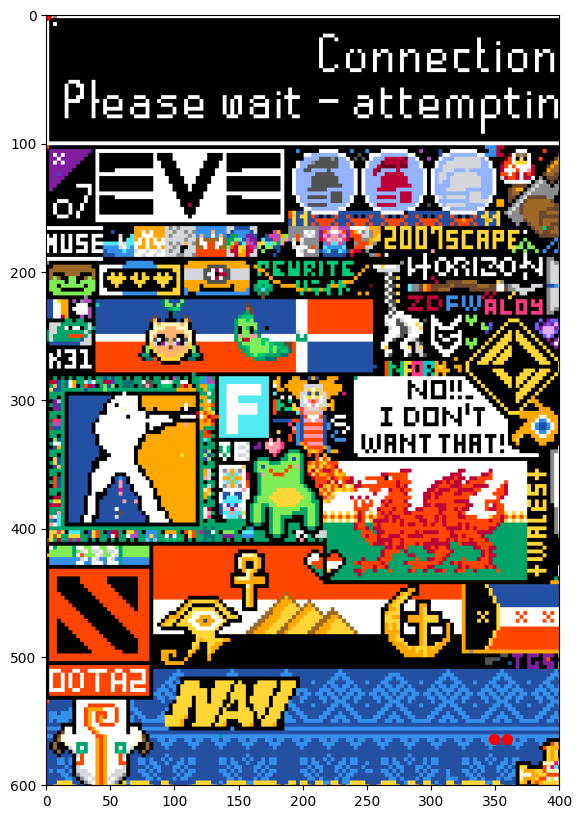

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

canvas = Image.open("2022_canvas_final.png") # load in final r/place 2022 canva

top_pixels = [(0, 0), (359, 564), (349, 564)]  # def most painted pixels

width, height = 400, 600 # zoom into these dim

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(canvas)

for (x, y) in top_pixels: # mark top pixels
    ax.scatter(x, y, color='red', s=50)

ax.set_xlim(0, width)  
ax.set_ylim(height, 0)  # invert y-axis to align with image coordinates

plt.show()

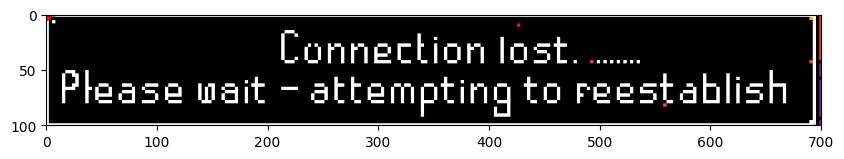

In [21]:
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(canvas)

# mark top pixels
for (x, y) in top_pixels:
    ax.scatter(x, y, color='red', s=50)  # red dot at pixel location

ax.set_xlim(0, 700)  # adjust 
ax.set_ylim(100, 0)
plt.show()

# Look at (0, 0) -> Connection Lost banner

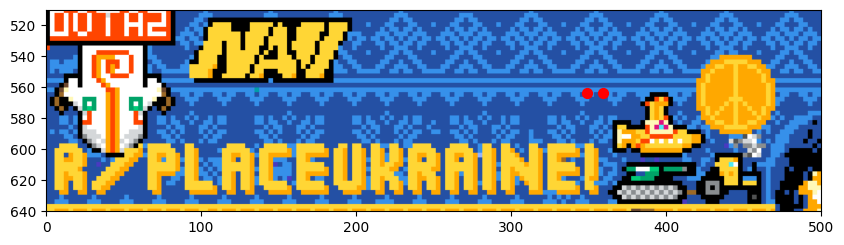

In [22]:
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(canvas)

# mark top pixels
for (x, y) in top_pixels:
    ax.scatter(x, y, color='red', s=50)  # red dot at pixel location

ax.set_xlim(0, 500)  # adjust 
ax.set_ylim(640, 510)
plt.show()

# Look at (359, 564) and (349, 564) -> R/PLACEUKRAINE banner

^^ do some online research on
- Connection Lost banner
    - users' response to Reddit removing their ability to place pixels 
    - were pixels on this banner painted on a lot?

- R/PLACEUKRAINE banner
    - most likely due to support for Ukraine after Russia-Ukraine war in 2022
    - were pixels on this banner painted on a lot? (just the background, blue part)

In [ ]:
# time visualization of changes on each banner?
# how did pixel color change over time
    # were people fighting over which color should be what? 
        # (0,0) seemed to be changing from black and white the most (and why orange/red color?)
        # other pixels changing from white and light blue (and why orange again?)
